In [2]:
import argparse
import cv2
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math

from keras.callbacks import Callback
from keras.models import model_from_json, Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU,Activation,BatchNormalization,LeakyReLU,ELU
from keras.layers.convolutional import Convolution2D,MaxPooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import scipy
import cv2
import re

np.random.seed(45)

Using TensorFlow backend.


In [3]:

new_size_col,new_size_row = 64, 64
input_shape=(new_size_row,new_size_col,3)

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def trans_image(image,steer,trans_range):
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 40*np.random.uniform()-40/2
    #tr_y = 0
    rows,cols,ch=image.shape
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,steer_ang

def preprocessImage(image):
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]/5):shape[0]-25, 0:shape[1]]
    image = cv2.resize(image,(new_size_col,new_size_row),interpolation=cv2.INTER_AREA)    
    #image = image/255.-.5
    return image

def preprocess_image_file_train(line_data):
    i_lrc = np.random.randint(3)
    if (i_lrc == 0):
        path_file = line_data['left'][0].strip()
        shift_ang = .25
    if (i_lrc == 1):
        path_file = line_data['center'][0].strip()
        shift_ang = 0.
    if (i_lrc == 2):
        path_file = line_data['right'][0].strip()
        shift_ang = -.25
    y_steer = line_data['steering'][0] + shift_ang
    image = cv2.imread(path_file)

    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
 
    image,y_steer= trans_image(image,y_steer,100)

    image = augment_brightness_camera_images(image)
 
    image = preprocessImage(image)

    image = np.array(image)

    ind_flip = np.random.randint(2)
    if ind_flip==0:
        image = cv2.flip(image,1)
        y_steer = -y_steer

    return image,y_steer

def generate_train_from_PD_batch(data,batch_size = 32):
    
    batch_images = np.zeros((batch_size, new_size_row, new_size_col, 3))
    batch_steering = np.zeros(batch_size)
    while 1:
        #batch_images=[]
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data))
            line_data = data.iloc[[i_line]].reset_index()
            
            keep_pr = 0
            #x,y = preprocess_image_file_train(line_data)
            while keep_pr == 0:
                x,y = preprocess_image_file_train(line_data)

                pr_unif = np.random
                if abs(y)<.1:
                    pr_val = np.random.uniform()
                    if pr_val>pr_threshold:
                        keep_pr = 1
                else:
                    keep_pr = 1
                 
            #x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            #y = np.array([[y]])
            #batch_images.append(x)
            batch_images[i_batch] = x
            batch_steering[i_batch] = y
        
        yield batch_images, batch_steering

In [4]:

dirpath = "data"
driveLog_fname = "{}/driving_log.csv".format(dirpath)
image_fdir = dirpath
drivelog = pd.read_csv(driveLog_fname)#,header=None,names=["center","left","right","steering","throttle","brake","speed"])


In [5]:

drivelog.center = drivelog.center.apply (lambda x: "{}/{}".format(dirpath, re.sub(r"^.*/IMG","IMG", x.strip())))
drivelog.left = drivelog.left.apply (lambda x: "{}/{}".format(dirpath, re.sub(r"^.*/IMG","IMG", x.strip())))
drivelog.right = drivelog.right.apply (lambda x: "{}/{}".format(dirpath, re.sub(r"^.*/IMG","IMG", x.strip())))

(32, 64, 64, 3)


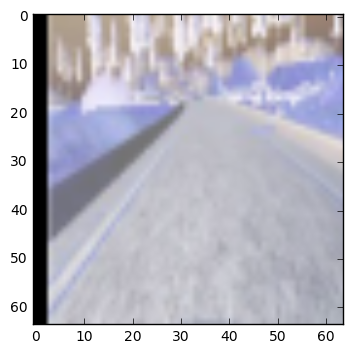

In [6]:
pr_threshold=1
test = generate_train_from_PD_batch(drivelog)
i=0
for x,y in test:
    print(x.shape)
    i+=1
    if i >0:
        break
        
        
plt.imshow(x[31])
plt.show()

In [7]:
def getModel(input_shape):

    model = Sequential()
    model.add(Lambda(
      lambda x: x/255.,
      input_shape=input_shape,
      output_shape=input_shape)
  )
#     model.add(Convolution2D(3, 1, 1, subsample=(2,2),border_mode="same",init="he_normal"))
#     model.add(ELU())
  
    
    model.add(Convolution2D(32, 3, 3,subsample=(2,2),border_mode="valid"))
    model.add(ELU())
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(64, 3, 3, subsample=(2,2),border_mode="valid"))
    model.add(ELU())
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(64, 3, 3,subsample=(1,1),border_mode="valid"))
    model.add(ELU())
    model.add(Flatten())
    model.add(Dropout(0.5))
              
#     model.add(Dense(512,init='uniform'))    
#     model.add(Dropout(0.5))
#     model.add(ELU())
              
    model.add(Dense(64,init='uniform'))
    model.add(Dropout(0.5))
    model.add(ELU())
    
    model.add(Dense(16,init='uniform'))
    model.add(Dropout(0.5))
    model.add(ELU())
              
    model.add(Dense(1))
    
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss="mse", metrics=['mse'])
    return model

In [8]:
def getModel2(input_shape):

    model = Sequential()
    model.add(Lambda(
      lambda x: x/255.,
      input_shape=input_shape,
      output_shape=input_shape)
  )
    model.add(Convolution2D(3, 1, 1, border_mode="same",init="he_normal"))
    model.add(LeakyReLU())
    
    
    model.add(Convolution2D(32, 3, 3, border_mode="same",init="he_normal")) 
    model.add(LeakyReLU())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(64, 3, 3, border_mode="same",init="he_normal"))
    model.add(LeakyReLU())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(64, 3, 3, border_mode="same",init="he_normal"))
    model.add(LeakyReLU())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    model.add(Dense(512,init='uniform'))    
    model.add(LeakyReLU())
    model.add(Dropout(0.5))
    
    model.add(Dense(64,init='uniform'))
    model.add(LeakyReLU())
    model.add(Dropout(0.5))
    
    model.add(Dense(16,init='uniform'))
    model.add(LeakyReLU())
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    
    optimizer = Adam()
    model.compile(optimizer=optimizer, loss="mse")
    return model

In [9]:
model = getModel2(input_shape)

In [10]:
model.load_weights("model.h5")

In [11]:
var_size =1
pr_threshold =1

batch_size = 250

for ep in range(8):
    data_gen = generate_train_from_PD_batch(drivelog,batch_size)
    hist = model.fit_generator(data_gen,samples_per_epoch = 20000, nb_epoch=1, verbose=1
                           #,validation_data=getBatch(valid_i,valid_s),nb_val_samples=valid_sample*1
                          )
    pr_threshold = 1/(1+ep)*1

Epoch 1/1
20000/20000 [==============================] - 80s - loss: 0.0313    
Epoch 1/1
20000/20000 [==============================] - 80s - loss: 0.0298    
Epoch 1/1
20000/20000 [==============================] - 71s - loss: 0.0287    
Epoch 1/1
20000/20000 [==============================] - 68s - loss: 0.0279    
Epoch 1/1
20000/20000 [==============================] - 66s - loss: 0.0273    
Epoch 1/1
20000/20000 [==============================] - 66s - loss: 0.0269    
Epoch 1/1
20000/20000 [==============================] - 65s - loss: 0.0275    
Epoch 1/1
20000/20000 [==============================] - 65s - loss: 0.0272    


In [12]:

with open('modelV6.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

In [13]:
model.save_weights('modelV6.h5')

In [15]:
images = drivelog.center.values
y_steer = drivelog.steering.values

In [62]:
y = y_steer[20]
print(y)
img = cv2.imread(images[20])
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img,y= trans_image(img,y_steer[0],100)
img = augment_brightness_camera_images(img)
img = preprocessImage(img)
img = np.array(img)
img = cv2.flip(img,1)

0.0


0.137829568659


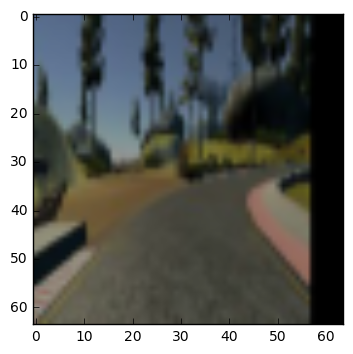

In [63]:
print(y)
plt.imshow(img)
plt.show()

In [47]:
test = generate_train_from_PD_batch(drivelog)

In [90]:
pr_threshold=1
test = generate_train_from_PD_batch(drivelog)



In [93]:
i = 0
for x,y in test:
    i+=1
    if i>0:
        break

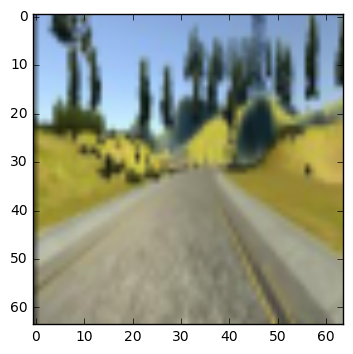

In [94]:
plt.imshow(x[0])
plt.show()